# Performing Logistic Regression
### in order to build a Predictor of the release year

In this notebook, we will be using the scikit-learn library to perform a logistic regression on the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from tueplots import bundles
plt.rcParams.update(bundles.neurips2021(usetex=False))

In [2]:
### import the datasets
train = pd.read_csv('../data/train_set.csv')
test = pd.read_csv('../data/test_set.csv')

In [29]:
polynomial_degree = -1

# helper func to put the data into bucket of timespans
timespan=1
min_year=1990

def calc_labels(years):
    return np.array([int((year-min_year)/timespan) for year in years])

def calc_years_from_label(label):
    start_year = label * timespan + min_year
    end_year = start_year + timespan - 1
    return start_year, end_year

This cell sorts the data and does some preprocessing, in order for the regression to work

In [30]:
predictors = ['explicit', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

X_train = train[predictors]
X_test = test[predictors]

scaler = preprocessing.StandardScaler().fit(pd.concat([train, test])[predictors])

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

y_train = calc_labels(train['year'])
y_test = calc_labels(test['year'])

In [31]:
if polynomial_degree != -1:
    poly = preprocessing.PolynomialFeatures(degree = polynomial_degree, interaction_only=False, include_bias=False)
    X_train = poly.fit_transform(X_train)
    X_test = poly.transform(X_test)

In [32]:
reg = LogisticRegression().fit(X_train, y_train)

In [33]:
reg.coef_.shape

(31, 13)

Fitting the sklearn Logistic Regression Model 

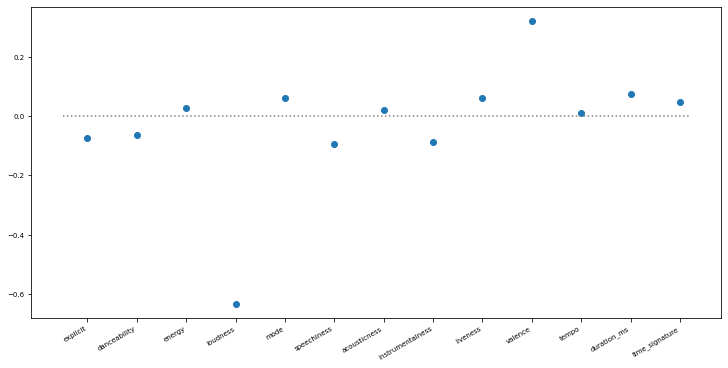

In [38]:
if polynomial_degree == -1:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(predictors, reg.coef_[0])
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    #ax.set_ylim([-1,1])
    ax.hlines(0,-.5, 12.2, colors='grey', linestyle='dotted')
    plt.show()

In [80]:
predicted_values = reg.predict(X_test)
random_values = np.random.randint(y_test.max(), size=(10,) + y_test.shape)

print(f'L1 Error of random: {np.array([np.abs(random - y_test).mean() for random in random_values]).mean()}')
print(f'L1 Error of predictor: {np.abs(predicted_values - y_test).mean()}')
print(f'Accuracy of random: {np.array([np.sum(random == y_test)/len(y_test) for random in random_values]).mean()}')
print(f'Accuracy of predictor: {reg.score(X_test, y_test)}')

L1 Error of random: 10.120883877985174
L1 Error of predictor: 7.596235415401686
Accuracy of random: 0.03138478877177042
Accuracy of predictor: 0.07885620929308108


In [72]:
# for i, coef in enumerate(reg.coef_):
#     sorted_ids = np.flip(np.argsort(np.abs(coef)))
#     start_year, end_year = calc_years_from_label(i)
#     print(f'timespan {i}: \n  years: {start_year}-{end_year} \n  tracks:{sum(y_test == i)} ')
#     for index in sorted_ids:    
#         print(f'     {predictors[index]}: {round(coef[index], 3)}')
# 

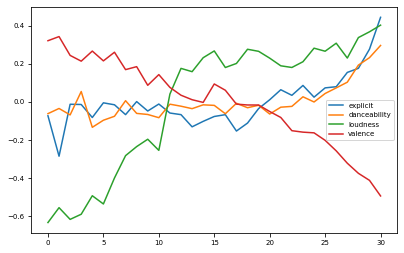

In [79]:
interesting_features = ['explicit', 'valence', 'loudness', 'danceability']
fig, ax = plt.subplots()

year_series = np.unique(calc_labels(np.unique(train['year'])))

for i,feature in enumerate(predictors):
    if feature in interesting_features:
        ax.plot(year_series, reg.coef_[:,i], '-', label=feature)
ax.legend()
#ax.set_ylim(-.6, .6)
plt.savefig('../figs/1_year_coefs.pdf',bbox_inches='tight')
plt.show()